EMNIST 복원을 위해 GAN과 CGAN을 시도해본 코드

# Setup Environment

In [ ]:
# Load Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data path
data_path = '/content/drive/MyDrive/3. KUBIG/2023-winter/2024-1 딥러닝/KUBIG_contest/data'

In [ ]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
# load data
train = pd.read_csv(data_path + '/train.csv')
test = pd.read_csv(data_path + '/test.csv')
submission = pd.read_csv(data_path + '/submission.csv')
cut150 = pd.read_csv(data_path + '/cut150.csv')

# GAN

Generative Adversarial Networks

## Setup generator and discriminator

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

In [ ]:
# Set Discriminator class
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)

        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out


In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

## Model hyperparameters

링크에 있는 디폴트 파라미터인데, epoch를 200으로 늘이면 잘 됨. z_size를 784로 만드는 경우 알아볼 수 없는 이미지가 나옴. input size를 이처럼 작은 수로 해야 하는 듯

In [ ]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100 #원래는 100이었는데, input size를 cut150으로 맞춰주려면 이렇게 해야 한다. 다시 100으로 복원
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Initiate Model

In [ ]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Define Loss Function

In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Define Optimizer

In [ ]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

## Train Model

In [ ]:
import pickle as pkl

# Set the random seed for CPU operations
torch.manual_seed(42)

# Set the random seed for CUDA operations (if using GPU)
torch.cuda.manual_seed_all(42)

# training hyperparams
num_epochs = 200

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16 # 16으로 해야 한다. 너무 크면 잘 못 알아봄
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        ## Important rescaling step ##
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        d_optimizer.zero_grad()

        # 1. Train with real images

        # Compute the discriminator losses on real images
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # 2. Train with fake images

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()

        # 1. Train with fake images and flipped labels

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels

        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))


    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  200] | d_loss: 1.1323 | g_loss: 1.2370
Epoch [    1/  200] | d_loss: 1.2328 | g_loss: 1.0040
Epoch [    1/  200] | d_loss: 1.0967 | g_loss: 1.2265
Epoch [    2/  200] | d_loss: 1.2582 | g_loss: 1.3338
Epoch [    2/  200] | d_loss: 1.2555 | g_loss: 0.9553
Epoch [    2/  200] | d_loss: 1.2108 | g_loss: 1.2284
Epoch [    3/  200] | d_loss: 1.1864 | g_loss: 0.9224
Epoch [    3/  200] | d_loss: 1.1708 | g_loss: 1.6004
Epoch [    3/  200] | d_loss: 1.3509 | g_loss: 1.5284
Epoch [    4/  200] | d_loss: 1.3290 | g_loss: 1.1795
Epoch [    4/  200] | d_loss: 1.2367 | g_loss: 1.7986
Epoch [    4/  200] | d_loss: 1.2554 | g_loss: 0.7502
Epoch [    5/  200] | d_loss: 1.3117 | g_loss: 1.1072
Epoch [    5/  200] | d_loss: 1.2647 | g_loss: 0.8857
Epoch [    5/  200] | d_loss: 1.5386 | g_loss: 0.8795
Epoch [    6/  200] | d_loss: 1.2614 | g_loss: 1.1156
Epoch [    6/  200] | d_loss: 1.2611 | g_loss: 1.4741
Epoch [    6/  200] | d_loss: 1.2781 | g_loss: 1.3880
Epoch [    7/  200] | d_loss

최종적으로 EMNIST (28x28)를 입력할 것이기 때문에 generator의 입력 개수는 784면 좋겠지만, 입력개수가 z_size = 100인게 훨씬 이미지가 깔끔하게 나온다.

학습하는데 38분 걸림 (100 epoch, generator hidden node 32, z_size=100)

학습하는데 19분 걸림 (50 epoch, generator hiddent node 16, z_size=784)

학습하는데 80분 걸림 (200 epoch, generator hiddent node 16, z_size=100)

## Plot Training Loss

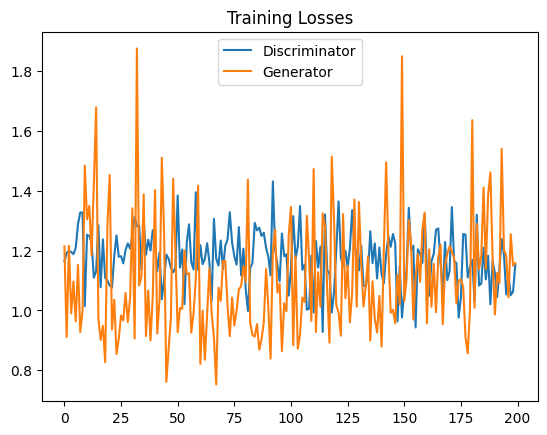

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Save and Load Model

## Save the model

In [ ]:
# Save the generator model
torch.save(G.state_dict(), data_path+'/generator.pth')

# Save the discriminator model
torch.save(D.state_dict(), data_path+'/discriminator.pth')

In [ ]:
# Load model
# Instantiate the generator and discriminator models
D = Discriminator(input_size, d_hidden_size, d_output_size) # Replace with the actual discriminator class
G = Generator(z_size, g_hidden_size, g_output_size) # Replace with the actual generator class

# Load the saved state_dicts
G.load_state_dict(torch.load(data_path+'/generator.pth'))
D.load_state_dict(torch.load(data_path+'/discriminator.pth'))

# Set the models to evaluation mode (important for dropout and batch normalization)
G.eval()
D.eval()

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Check Model Training Progress

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

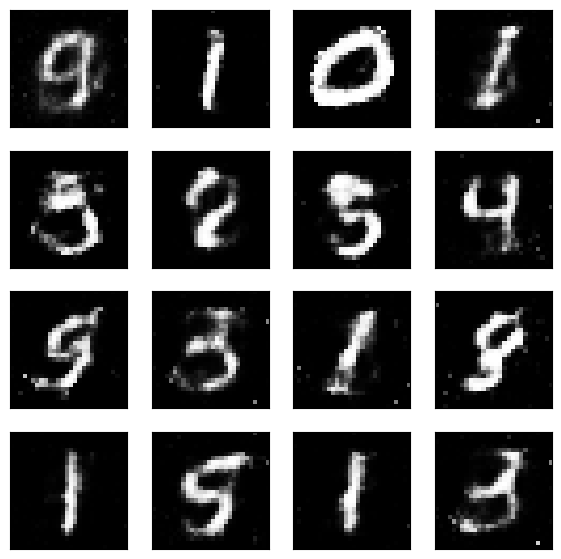

In [ ]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

### Progress of training

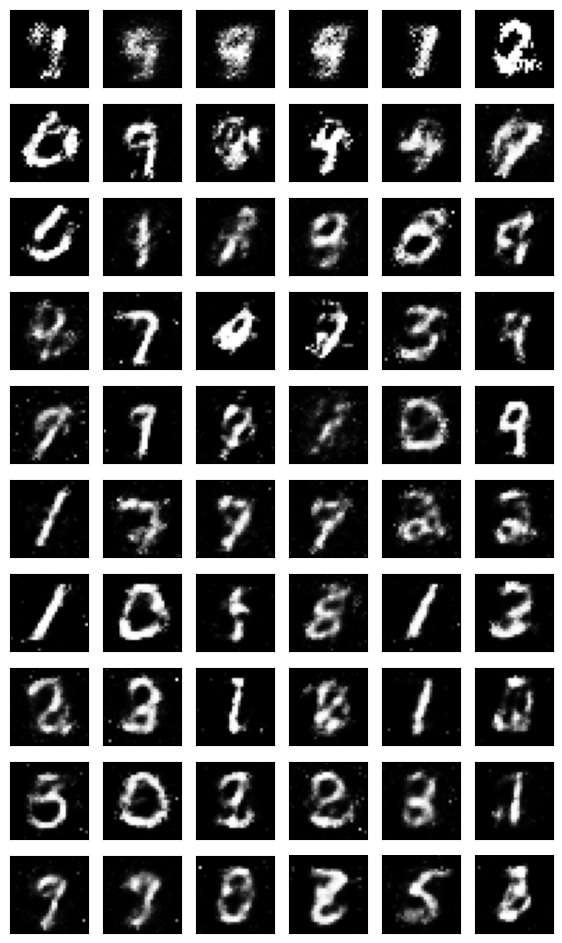

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Check Model Generation

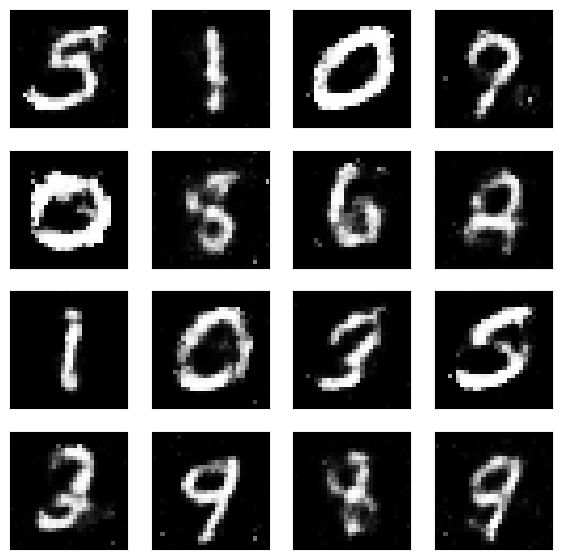

In [ ]:
# randomly generated, new latent vectors
sample_size=2048
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

## Impaint Train Set

## Sample from train set

In [ ]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
# divide pixel information and label information
pixel_train = train[[col for col in train.columns if col not in ['id', 'digit', 'letter']]]
label_train = train[['id', 'digit', 'letter']]

In [ ]:
# normalize pixel values
pixel_train_tensor = torch.tensor(pixel_train.values, dtype=torch.float32)
normalized_pixel_train = pixel_train_tensor / 255.0

In [ ]:
# Example tensor with dimensions (28, 28, 2048)
mnist_tensor = torch.randn(2048, 28, 28)
mnist_tensor[0].shape

torch.Size([28, 28])

In [ ]:
# Resize 28x28 image to 10x10 so that it can be used as input of generator
resized_tensor_train = normalized_pixel_train.view(-1, 28, 28)

# Resize the images to 10x10 using torch.nn.functional.interpolate
resized_tensor_train = torch.nn.functional.interpolate(resized_tensor_train.unsqueeze(1), size=(10, 10), mode='bilinear', align_corners=False)
resized_tensor_train = resized_tensor_train.squeeze(1)

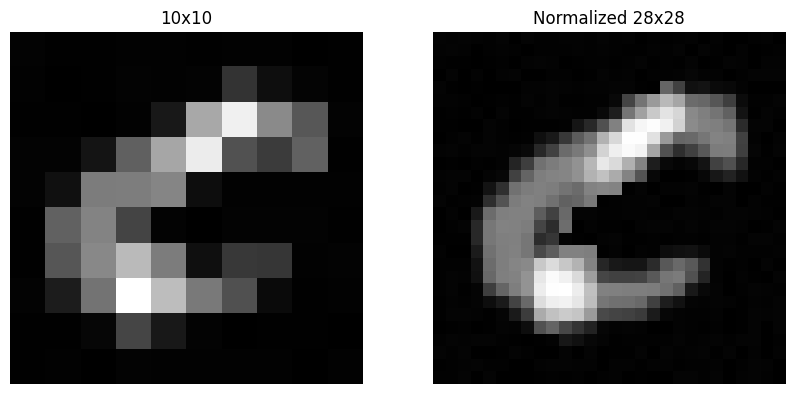

In [ ]:
# Assuming images_with_holes is a batch of images with holes
# and inpainted_images is the corresponding inpainted batch
random_int = np.random.randint(0, 2048, 1)

# Display the original images with holes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(resized_tensor_train[random_int].reshape(10, 10), cmap='gray')
axs[0].set_title('10x10')
axs[0].axis('off')

# Display the original
axs[1].imshow(normalized_pixel_train[random_int].reshape(28, 28), cmap='gray')
axs[1].set_title('Normalized 28x28')
axs[1].axis('off')

plt.show()

In [ ]:
# Use the trained generator for inpainting
def inpaint_images(images_with_holes):
    G.eval()
    with torch.no_grad():
        inpainted_images = G(images_with_holes.to(device))
    return inpainted_images.cpu()

In [ ]:
inpainted_images_train = inpaint_images(resized_tensor_train.view(-1, 100))

<ipython-input-151-d6aeaac4ff6e>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_int = int(np.random.randint(0, 2048, 1))


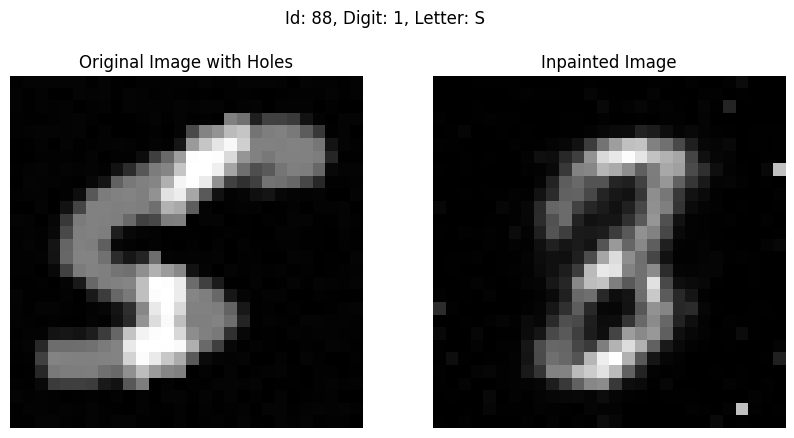

In [ ]:
# Random one
# Assuming images_with_holes is a batch of images with holes
# and inpainted_images is the corresponding inpainted batch

random_int = int(np.random.randint(0, 2048, 1))
id = train.loc[random_int, 'id']
digit = train.loc[random_int, 'digit']
letter = train.loc[random_int, 'letter']


# Display the original images with holes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(normalized_pixel_train[random_int].reshape(28, 28), cmap='gray')
axs[0].set_title('Original Image with Holes')
axs[0].axis('off')

# Display the inpainted images
axs[1].imshow(inpainted_images_train[random_int].reshape((28, 28)), cmap='gray')
axs[1].set_title('Inpainted Image')
axs[1].axis('off')

plt.suptitle('Id: %i, Digit: %s, Letter: %s'%(id, digit, letter))
plt.show()

## Inpaint cut150 dataset

In [ ]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
# divide pixel and label information
pixel = cut150[[col for col in train.columns if col not in ['id', 'digit', 'letter']]]
label = cut150[['id', 'digit', 'letter']]

In [ ]:
# noramlize pixels
pixel_tensor = torch.tensor(pixel.values, dtype=torch.float32)
normalized_pixel = pixel_tensor / 255.0

In [ ]:
pixel_tensor.shape

torch.Size([2048, 784])

In [ ]:
# Example tensor with dimensions (28, 28, 2048)
mnist_tensor = torch.randn(2048, 28, 28)
mnist_tensor[0].shape

torch.Size([28, 28])

In [ ]:
# resize 28x28 image to 10x10 so that it can be used as input in generator
resized_tensor = normalized_pixel.view(-1, 28, 28)

# Resize the images to 10x10 using torch.nn.functional.interpolate
resized_tensor = torch.nn.functional.interpolate(resized_tensor.unsqueeze(1), size=(10, 10), mode='bilinear', align_corners=False)
resized_tensor = resized_tensor.squeeze(1)

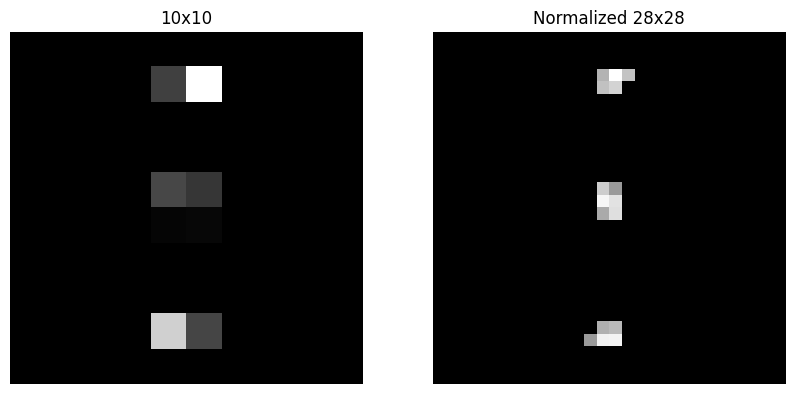

In [ ]:
# Assuming images_with_holes is a batch of images with holes
# and inpainted_images is the corresponding inpainted batch

# Display the original images with holes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(resized_tensor[0], cmap='gray')
axs[0].set_title('10x10')
axs[0].axis('off')

# Display the inpainted images
axs[1].imshow(normalized_pixel[0].reshape((28, 28)), cmap='gray')
axs[1].set_title('Normalized 28x28')
axs[1].axis('off')

plt.show()

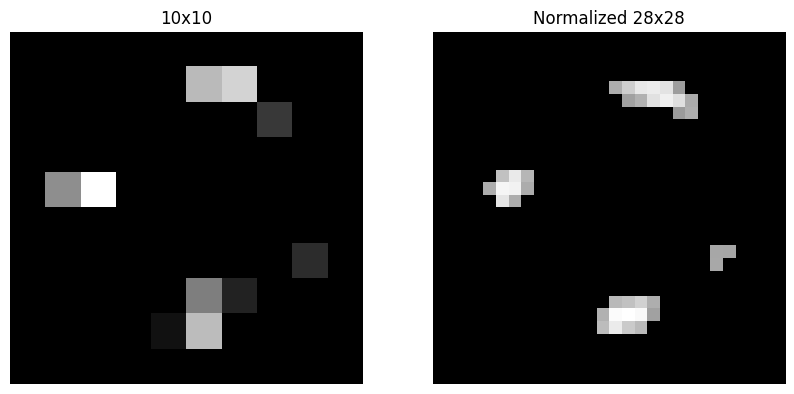

In [ ]:
# compare random images
random_int = np.random.randint(0, 2048, 1)

# Assuming images_with_holes is a batch of images with holes
# and inpainted_images is the corresponding inpainted batch

# Display the original images with holes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(resized_tensor[random_int].reshape(10, 10), cmap='gray')
axs[0].set_title('10x10')
axs[0].axis('off')

# Display the inpainted images
axs[1].imshow(normalized_pixel[random_int].reshape((28, 28)), cmap='gray')
axs[1].set_title('Normalized 28x28')
axs[1].axis('off')

plt.show()

In [ ]:
# Use the trained generator for inpainting
def inpaint_images(images_with_holes):
    G.eval()
    with torch.no_grad():
        inpainted_images = G(images_with_holes.to(device))
    return inpainted_images.cpu()

In [ ]:
# inpaint images
inpainted_images = inpaint_images(resized_tensor.view(-1, 100))

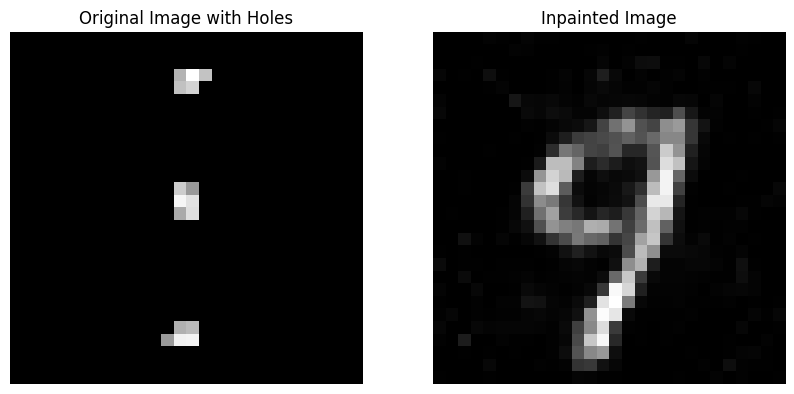

In [ ]:
# First one
# Assuming images_with_holes is a batch of images with holes
# and inpainted_images is the corresponding inpainted batch

# Display the original images with holes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(normalized_pixel[0].reshape(28, 28), cmap='gray')
axs[0].set_title('Original Image with Holes')
axs[0].axis('off')

# Display the inpainted images
axs[1].imshow(inpainted_images[0].reshape((28, 28)), cmap='gray')
axs[1].set_title('Inpainted Image')
axs[1].axis('off')

plt.show()

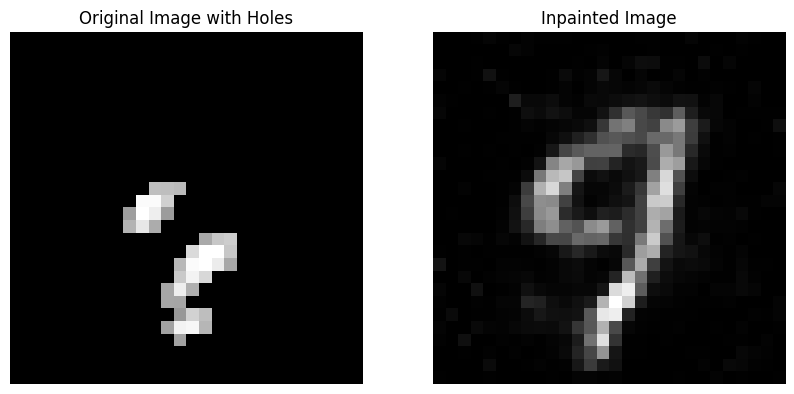

In [ ]:
# Random one
# Assuming images_with_holes is a batch of images with holes
# and inpainted_images is the corresponding inpainted batch

random_int = np.random.randint(0, 2048, 1)

# Display the original images with holes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(normalized_pixel[random_int].reshape(28, 28), cmap='gray')
axs[0].set_title('Original Image with Holes')
axs[0].axis('off')

# Display the inpainted images
axs[1].imshow(inpainted_images[random_int].reshape((28, 28)), cmap='gray')
axs[1].set_title('Inpainted Image')
axs[1].axis('off')

plt.show()

In [ ]:
inpainted_images = (inpainted_images + 1)/2

In [ ]:
# save dataframe
# Convert the PyTorch tensor to a NumPy array
numpy_array = inpainted_images.numpy()

# Create a DataFrame from the NumPy array
columns = [f'{i}' for i in range(784)]
df = pd.DataFrame(numpy_array, columns=columns)

inpainted = pd.concat([label, df], axis = 1)
inpainted.to_csv(data_path+'/inpainted.csv', index = True)

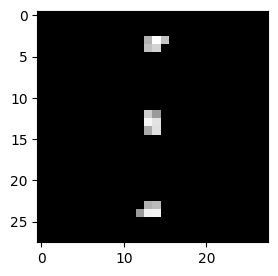

In [ ]:
# get one image from the batch
img = normalized_pixel[0].reshape(28, 28)

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

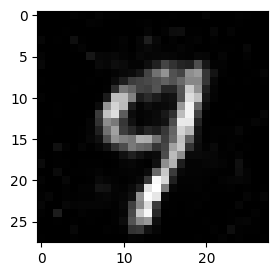

In [ ]:
# get one image from the batch
img = inpainted_images[0].reshape(28, 28)

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Plot Image



In [ ]:
# Plot one by one
for i in range(len(normalized_pixel)):
  images = inpainted_images[i].reshape(28, 28)
  id = train.loc[i, 'id']
  digit = train.loc[i, 'digit']
  letter = train.loc[i, 'letter']
  plt.imshow(images, cmap='binary')
  plt.title('Id: %i, Digit: %s, Letter: %s'%(id, digit, letter))
  plt.show()


In [ ]:
# Create a 204x10 grid of subplots
fig, axes = plt.subplots(nrows=205, ncols=10, figsize=(30, 600))

# Iterate through the grid and plot each image

#define number of rows and columns for subplots
for i in range(204):
    for j in range(10):
      images = inpainted_images[i * 10 + j].reshape(28, 28)

      id = train.loc[i * 10 + j, 'id']
      digit = train.loc[i * 10 + j, 'digit']
      letter = train.loc[i * 10 + j, 'letter']
      axes[i, j].imshow(images, cmap='binary')
      axes[i, j].axis('off')  # Turn off axis labels for clarity
      axes[i, j].set_title('Id: %i, Digit: %s, Letter: %s'%(id, digit, letter))

# plt.suptitle('Images of one', fontsize=16)
plt.show()

# CGAN

## Setup CGAN hyperparameters

In [ ]:
# Hyper-parameters & Variables setting
num_epoch = 200
batch_size = 100
learning_rate = 0.0002
img_size = 28 * 28
num_channel = 1
dir_name = "CGAN_results"

noise_size = 100
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024

In [ ]:
"""
FOR CONDITIONAL GAN
"""
# The number of MNIST's class label is 10
condition_size = 10


In [ ]:
# Device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Now using {} devices".format(device))

Now using cpu devices


In [ ]:
# Create a directory for saving samples
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

## Setup Generator and Discriminator

In [ ]:
# Define discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.linear1 = nn.Linear(img_size + condition_size, hidden_size3)
        self.linear2 = nn.Linear(hidden_size3, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size1)
        self.linear4 = nn.Linear(hidden_size1, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.linear1(x))
        x = self.leaky_relu(self.linear2(x))
        x = self.leaky_relu(self.linear3(x))
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

In [ ]:
# Define generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(noise_size + condition_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, img_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = self.tanh(x)
        return x

## Train MNIST to CGAN

In [ ]:
# For checking CGAN's validity in final step
def check_condition(_generator):
    test_image = torch.empty(0).to(device)

    for i in range(10):
        test_label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        test_label_encoded = F.one_hot(test_label, num_classes=10).to(device)

        # create noise(latent vector) 'z'
        _z = torch.randn(10, noise_size).to(device)
        _z_concat = torch.cat((_z, test_label_encoded), 1)

        test_image = torch.cat((test_image, _generator(_z_concat)), 0)

    _result = test_image.reshape(100, 1, 28, 28)
    save_image(_result, os.path.join(dir_name, 'CGAN_test_result.png'), nrow=10)

In [ ]:
test_label0 = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
test_label_encoded0 = F.one_hot(test_label0, num_classes=10)
test_label_encoded0

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [ ]:
# Dataset transform setting
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)])

In [ ]:
# MNIST dataset setting
MNIST_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True,
                                           transform=transform,
                                           download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 187477278.75it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 47766440.78it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68703410.36it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12950733.36it/s]


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



## Initiate Model

In [ ]:
# Initialize generator/Discriminator
discriminator = Discriminator()
generator = Generator()

# Device setting
discriminator = discriminator.to(device)
generator = generator.to(device)

# Loss function & Optimizer setting
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

## Train model

In [ ]:
"""
Training part
"""
for epoch in range(num_epoch):
    for i, (images, label) in enumerate(data_loader):

        # make ground truth (labels) -> 1 for real, 0 for fake
        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)

        # reshape real images from MNIST dataset
        real_images = images.reshape(batch_size, -1).to(device)

        """
        FOR CONDITIONAL GAN
        """
        # Encode MNIST's label's with 'one hot encoding'
        label_encoded = F.one_hot(label, num_classes=10).to(device)
        # concat real images with 'label encoded vector'
        real_images_concat = torch.cat((real_images, label_encoded), 1)

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # Initialize grad
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()

        # make fake images with generator & noise vector 'z'
        z = torch.randn(batch_size, noise_size).to(device)

        """
        FOR CONDITIONAL GAN
        """
        # concat noise vector z with encoded labels
        z_concat = torch.cat((z, label_encoded), 1)
        fake_images = generator(z_concat)
        fake_images_concat = torch.cat((fake_images, label_encoded), 1)

        # Compare result of discriminator with fake images & real labels
        # If generator deceives discriminator, g_loss will decrease
        g_loss = criterion(discriminator(fake_images_concat), real_label)

        # Train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # Initialize grad
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        # make fake images with generator & noise vector 'z'
        z = torch.randn(batch_size, noise_size).to(device)

        """
        FOR CONDITIONAL GAN
        """
        # concat noise vector z with encoded labels
        z_concat = torch.cat((z, label_encoded), 1)
        fake_images = generator(z_concat)
        fake_images_concat = torch.cat((fake_images, label_encoded), 1)

        # Calculate fake & real loss with generated images above & real images
        fake_loss = criterion(discriminator(fake_images_concat), fake_label)
        real_loss = criterion(discriminator(real_images_concat), real_label)
        d_loss = (fake_loss + real_loss) / 2

        # Train discriminator with backpropagation
        # In this part, we don't train generator
        d_loss.backward()
        d_optimizer.step()

        d_performance = discriminator(real_images_concat).mean()
        g_performance = discriminator(fake_images_concat).mean()

        if (i + 1) % 150 == 0:
            print("Epoch [ {}/{} ]  Step [ {}/{} ]  d_loss : {:.5f}  g_loss : {:.5f}"
                  .format(epoch + 1, num_epoch, i+1, len(data_loader), d_loss.item(), g_loss.item()))

    # print discriminator & generator's performance
    print(" Epock {}'s discriminator performance : {:.2f}  generator performance : {:.2f}"
          .format(epoch + 1, d_performance, g_performance))

    # Save fake images in each epoch
    samples = fake_images.reshape(batch_size, 1, 28, 28)
    save_image(samples, os.path.join(dir_name, 'CGAN_fake_samples{}.png'.format(epoch + 1)))
    # print("label of 'CGAN_fake_samples{}.png' is {}".format(epoch + 1, label))

    # Draw real labels on fake sample images
    # If you got error about this, you can remove lines below
    fake_sample_image = Image.open("{}/CGAN_fake_samples{}.png".format(dir_name, epoch + 1))

    label = label.tolist()
    label = label[:10]
    label = [str(l) for l in label]

    label_text = ", ".join(label)
    label_text = "Conditional GAN -\n" \
                 "first 10 labels in this image :\n" + label_text

    image_edit = ImageDraw.Draw(fake_sample_image)
    image_edit.multiline_text(xy=(15, 300),
                              text=label_text,
                              fill=(0, 255, 255),
                              stroke_width= 4,
                              stroke_fill=(0, 0, 0))
    fake_sample_image.save("{}/CGAN_fake_samples{}.png".format(dir_name, epoch + 1))

Epoch [ 1/200 ]  Step [ 150/600 ]  d_loss : 0.00448  g_loss : 8.59541
Epoch [ 1/200 ]  Step [ 300/600 ]  d_loss : 0.00022  g_loss : 8.56090
Epoch [ 1/200 ]  Step [ 450/600 ]  d_loss : 0.00034  g_loss : 8.22970
Epoch [ 1/200 ]  Step [ 600/600 ]  d_loss : 0.07131  g_loss : 7.89021
 Epock 1's discriminator performance : 0.94  generator performance : 0.01
Epoch [ 2/200 ]  Step [ 150/600 ]  d_loss : 0.00479  g_loss : 15.47943
Epoch [ 2/200 ]  Step [ 300/600 ]  d_loss : 0.89568  g_loss : 6.22769
Epoch [ 2/200 ]  Step [ 450/600 ]  d_loss : 0.52505  g_loss : 14.49233
Epoch [ 2/200 ]  Step [ 600/600 ]  d_loss : 2.45595  g_loss : 18.33798
 Epock 2's discriminator performance : 0.94  generator performance : 0.10
Epoch [ 3/200 ]  Step [ 150/600 ]  d_loss : 0.15594  g_loss : 3.27494
Epoch [ 3/200 ]  Step [ 300/600 ]  d_loss : 0.35852  g_loss : 2.78674
Epoch [ 3/200 ]  Step [ 450/600 ]  d_loss : 0.56290  g_loss : 3.55188
Epoch [ 3/200 ]  Step [ 600/600 ]  d_loss : 0.36705  g_loss : 4.01766
 Epock 3'

In [ ]:
# Check conditional GAN by using user-selected labels as condition value
check_condition(generator)

## Save and Load Model

In [ ]:
# Save the generator model
torch.save(generator.state_dict(), data_path+'/CGAN_trained_generator_full.pth')

# Save the discriminator model
torch.save(discriminator.state_dict(), data_path+'/CGAN_trained_discriminator_full.pth')

In [ ]:
# Load model
# Instantiate the generator and discriminator models
discriminator = Discriminator() # Replace with the actual discriminator class
generator = Generator() # Replace with the actual generator class

# Load the saved state_dicts
generator.load_state_dict(torch.load(data_path+'/CGAN_trained_generator_full.pth'))
discriminator.load_state_dict(torch.load(data_path+'/CGAN_trained_discriminator_full.pth'))

# Set the models to evaluation mode (important for dropout and batch normalization)
generator.eval()
discriminator.eval()

Discriminator(
  (linear1): Linear(in_features=794, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)

## Resize image

In [ ]:
# Example tensor with dimensions (28, 28, 2048)
mnist_tensor = torch.randn(28, 28, 2048)

# Reshape the tensor to (2048, 1, 28, 28) for compatibility with F.interpolate
mnist_tensor_reshaped = mnist_tensor.permute(2, 0, 1).unsqueeze(1)

# Use F.interpolate to resize to (2048, 1, 10, 10)
resized_tensor = F.interpolate(mnist_tensor_reshaped, size=(10, 10), mode='bilinear', align_corners=False)

# Reshape the tensor back to (28, 28, 2048)
resized_tensor = resized_tensor.squeeze(1).permute(1, 2, 0)

# Display the resized tensor shape
print(resized_tensor.shape)

torch.Size([10, 10, 2048])


## EMNIST cut150 inprint

In [ ]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Use the trained generator for inpainting
def inpaint_images(images_with_holes):
    generator.eval()
    with torch.no_grad():
        inpainted_images = generator(images_with_holes.to(device))
    return inpainted_images.cpu()

In [ ]:
# preprocess data so that it can be used as input
pixel = cut150[[col for col in train.columns if col not in ['id', 'digit', 'letter']]]
label = cut150[['id', 'digit', 'letter']]
label_encode = F.one_hot(torch.tensor(label['digit']), num_classes=10)

In [ ]:
pixel_tensor = torch.tensor(pixel.values, dtype=torch.float32)
normalized_pixel = pixel_tensor / 255.0

In [ ]:
# resize image
resized_tensor = normalized_pixel.view(-1, 28, 28)

# Resize the images to 10x10 using torch.nn.functional.interpolate
resized_tensor = torch.nn.functional.interpolate(resized_tensor.unsqueeze(1), size=(10, 10), mode='bilinear', align_corners=False)
resized_tensor = resized_tensor.squeeze(1)

In [ ]:
# make input = image + label ---> good
input = torch.cat((resized_tensor.reshape(2048, 100), label_encode), dim=1)

In [ ]:
inpainted_images = inpaint_images(input)

In [ ]:
# un-normalize pixel values
inpainted_images = (inpainted_images + 1)/2

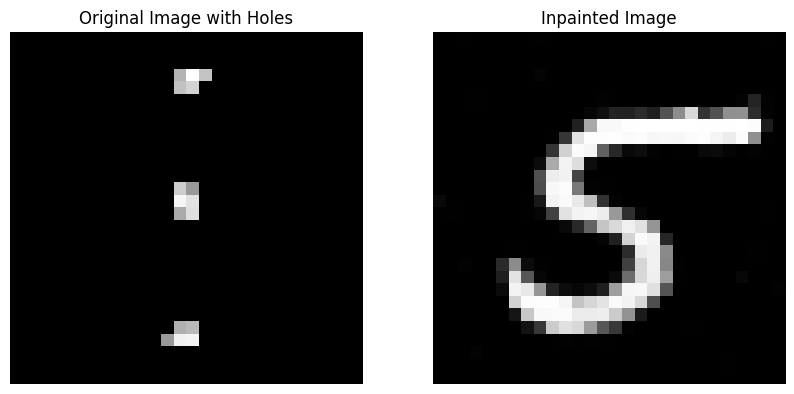

In [ ]:
# Assuming images_with_holes is a batch of images with holes
# and inpainted_images is the corresponding inpainted batch

# Display the original images with holes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(normalized_pixel[0].reshape(28, 28), cmap='gray')
axs[0].set_title('Original Image with Holes')
axs[0].axis('off')

# Display the inpainted images
axs[1].imshow(inpainted_images[0].reshape((28, 28)), cmap='gray')
axs[1].set_title('Inpainted Image')
axs[1].axis('off')

plt.show()

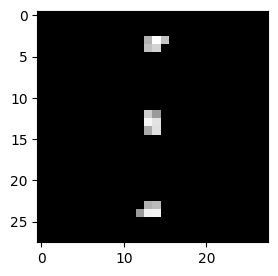

In [ ]:
# get one image from the batch
img = normalized_pixel[0].reshape(28, 28)

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

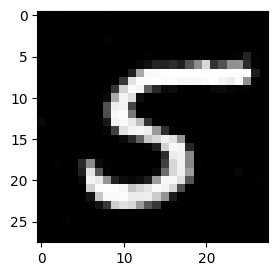

In [ ]:
# get one image from the batch
img = inpainted_images[0].reshape(28, 28)

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Plot Image



In [ ]:
# Plot one by one
for i in range(len(normalized_pixel)):
  images = inpainted_images[i].reshape(28, 28)
  id = train.loc[i, 'id']
  digit = train.loc[i, 'digit']
  letter = train.loc[i, 'letter']
  plt.imshow(images, cmap='binary')
  plt.title('Id: %i, Digit: %s, Letter: %s'%(id, digit, letter))
  plt.show()


In [ ]:
# Create a 2048x10 grid of subplots
fig, axes = plt.subplots(nrows=205, ncols=10, figsize=(30, 600))

# Iterate through the grid and plot each image

#define number of rows and columns for subplots
for i in range(204):
    for j in range(10):
      images = inpainted_images[i * 10 + j].reshape(28, 28)

      id = train.loc[i * 10 + j, 'id']
      digit = train.loc[i * 10 + j, 'digit']
      letter = train.loc[i * 10 + j, 'letter']
      axes[i, j].imshow(images, cmap='binary')
      axes[i, j].axis('off')  # Turn off axis labels for clarity
      axes[i, j].set_title('Id: %i, Digit: %s, Letter: %s'%(id, digit, letter))

# plt.suptitle('Images of one', fontsize=16)
plt.show()